# Programming for Data Science and Artificial Intelligence

## Supervised Learning - Classification - K-Nearest Neighbors

## Name: Thantham  Khamyai

## Studuet ID: 122097

## Tasks to be completed

* Making model pick output as **second class if the frequency of two classes are equivalent**
* Making the way to **output the probability** of each class
* Let the model can do **Cross-Validation** to find the best **k** parameter by define **range of k**
* Put every thing into a class

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Generate Samples Data

First, we have to generate sample data using make_blobs function that provides multi-classes dataset following defined parameters 

Text(0.5, 1.0, 'Scatter plot of Samples')

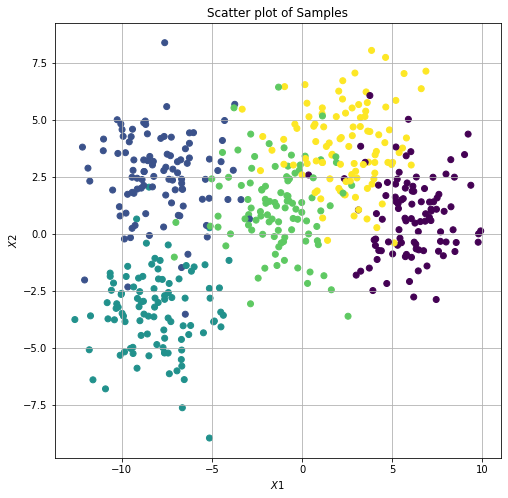

In [2]:

X, y = make_blobs(n_samples=500, centers=5,
                  random_state=999, cluster_std=1.8)

figure = plt.figure(figsize=(8, 8))
ax = plt.axes()  #get the instance of axes from plt

ax.grid(True)
ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set_xlabel('$X1$')
ax.set_ylabel('$X2$')
ax.set_title('Scatter plot of Samples')

This lab work is more challenge. The generated data contains 5 classes from 500 samples in 2 dimension features despite more closer (from random_state=999) and spread (std = 1.8) for seeing how model does. The scatter plot showing as above

## Feature Scaling and Train/Test Set Spltiting

Lets scale the features to better convergence and split them into training and testing set

In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## K Nearest Neighbors Classifier class

KNN is a distance-based classifier which needs high computaional cost because it required to calculate all possible distance for each training set and test set. Moreover, it does not need the training step, but it will do calculation during prediction.

However, there are just a few step to do classification.

1. Calculate all **distance** between training set and testing set
2. **Sorting** shortest distance and **Picking 'k'** number of member of training points that are nearest to the testing points
3. find majority class that highest frequency in **k** members using $argmax$
4. conclude all classes for y predicted


However, I will make it be easier to be used for this model. I have kept the usable step of KNN being similar to Scikit-learn way which we have to make the step of fit and predict.

In [4]:
class KNN:
    
    # Constructor will obtrain k =3 and False flag for second pick option with cv = 5
    def __init__(self, k=3, second_pick=False, cv=5):
        self.k = k
        self.second_pick = second_pick
        self.cv = cv
        
        # If received k is integer -> this model is single k mode
        if isinstance(self.k, int):
            self.fit_method = 'single'
        elif isinstance(self.k, (np.ndarray, list)):
            self.fit_method = 'cv'
        else:
            raise ValueError("""Invalid k datatype, accept only: {'int', 'list', 'numpy.ndarray'}""")
        
    def fit(self, X, y):
        
        if self.fit_method == 'single':
            self.X_train = X
            self.y_train = y
            self.n_class = len(np.unique(self.y_train))
        else: 
            self.fit_cv(X, y) # point to cv fitting function
            
        
    def predict(self, X_test):
        
        if self.fit_method == 'single': # if fit method is single k
            neighbors_ix = self.find_neighbors(X_test) # find nearest idx of train to test
            pred = np.zeros(X_test.shape[0]) # init pred result
            for ix, y in enumerate(self.y_train[neighbors_ix]): # for each prediction
                pred[ix] = self.get_most_common(y) # get output class
            return pred
        
        elif self.fit_method == 'cv': # if fit method is cv
            neighbors_ix = self._find_neighbors_cv(self.X_train, X_test, self.best_k_) # just reuse best k
            pred = np.zeros(X_test.shape[0]) # init pred result
            for ix, y in enumerate(self.y_train[neighbors_ix]): # for each prediction
                pred[ix] = self.get_most_common(y) # get output class
            return pred
        else:
            print('Error: fit method is invalid')

    def predict_proba(self, X_test):
        
        if self.fit_method =='single':
            
            neighbors_ix = self.find_neighbors(X_test)
            y_pred_count = self.y_train[neighbors_ix] # get class nearest
            pred = np.zeros((X_test.shape[0], self.n_class)) # init proba prediction
            
            for i in range(y_pred_count.shape[0]): # each prediction
                pred[i] = np.bincount(y_pred_count[i], minlength=self.n_class) # just count the bins
            return pred/self.k # return counted bin / k
        
        elif self.fit_method =='cv':
            
            neighbors_ix = self._find_neighbors_cv(self.X_train, X_test, self.best_k_) # reuse best k 
            y_pred_count = self.y_train[neighbors_ix]# get class nearest
            pred = np.zeros((X_test.shape[0], self.n_class))
            
            for i in range(y_pred_count.shape[0]):
                pred[i] = np.bincount(y_pred_count[i], minlength=self.n_class) # just count the bins
            return pred/self.best_k_ # return counted bin / k
    
    def fit_cv(self, X_train, y_train):
        
        # Keep X and y
        self.X_train = X_train
        self.y_train = y_train
        self.n_class = len(np.unique(y_train))
        
        # split x and y into chunks
        X_folds = np.array(np.array_split(self.X_train, self.cv))
        y_folds = np.array(np.array_split(self.y_train, self.cv))
       
        # init cv score and proba
        self.yhat_cv = np.zeros((len(self.k), self.cv))
        self.yhat_cv_prob = np.zeros((len(self.k), self.cv))
        
        print(f'Number of k : {len(self.k)} \nNumber of folds: {self.cv}')
        print(f'Total fitting: {len(self.k)*self.cv}')
        
        # for each k
        for k_idx, current_k in enumerate(self.k):
            
            # for each folds
            for fold_idx in range(len(X_folds)):
                
                # define validation fold
                X_val_ = X_folds[fold_idx]
                y_val_ = y_folds[fold_idx]
    
                # stack up the rest of non validation folds
                X_fit_ = np.concatenate(np.delete(X_folds, [fold_idx], axis=0))
                y_fit_ = np.concatenate(np.delete(y_folds, [fold_idx], axis=0))
                
                # do predict
                yhat_int, yhat_prob = self._predict_cv(X_fit_,X_val_, y_fit_, current_k)
                
                # calc accuracy
                accuracy = np.sum(yhat_int == y_val_)/len(y_val_)
                
                # append up the accuracy and probability
                self.yhat_cv[k_idx, fold_idx] = accuracy
                self.yhat_cv_prob[k_idx, fold_idx] = np.mean(np.max(yhat_prob, axis=1))
        
        # after run CV, get k which gives highest mean of acc*prob
        self.best_k_ = self.k[np.argmax(np.mean(self.yhat_cv, axis=1)*np.mean(self.yhat_cv_prob, axis=1))]
        
    
    def _predict_cv(self, X_fit, X_val, y_fit, current_k):
        neighbors_ix = self._find_neighbors_cv(X_fit, X_val, current_k)
        y_pred_count = y_fit[neighbors_ix]
        pred_proba = np.zeros((X_val.shape[0], self.n_class))
        pred_int = np.zeros(X_val.shape[0])
        for i in range(y_pred_count.shape[0]):
            pred_proba[i] = np.bincount(y_pred_count[i], minlength=self.n_class)
            pred_int[i] = self.get_most_common(y_pred_count[i])
        return pred_int, pred_proba/current_k
    
    # ---------------- Singlemode -------------------------------------------------
    def find_distance(self, X_test):
        #create newaxis simply so that broadcast to all values
        dist = X_test[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]
        sq_dist = dist ** 2

        #sum across feature dimension, thus axis = 2
        summed_dist = sq_dist.sum(axis=2)
        sq_dist = np.sqrt(summed_dist)
        return sq_dist
    
    def find_neighbors(self, X_test_):
        dist = self.find_distance(X_test_)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)[:, 0:self.k]
        return neighbors_ix
    
    # -------------------CV mode ----------(implement temporary k)----------------
    def _find_distance_cv(self, X_train, X_val):
        dist = X_val[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        sq_dist = dist ** 2
        summed_dist = sq_dist.sum(axis=2)
        sq_dist = np.sqrt(summed_dist)
        return sq_dist
    
    def _find_neighbors_cv(self, X_train, X_val, current_k):
        dist = self._find_distance_cv(X_train, X_val)
        neighbors_idx = np.argsort(dist)[:, 0:current_k]
        return neighbors_idx
    
    def get_most_common(self, y):
        
        # if option second_pick (allow decide second equivalent freq. class)
        if self.second_pick:
            
            # count the bin of classes
            y_bin = np.bincount(y, minlength=self.n_class)
            # sorting the freq.
            idx_2_max = (-y_bin).argsort()
            
            # check if first 2 freq. are equal
            if y_bin[idx_2_max[0]] == y_bin[idx_2_max[1]]:
                # return c a class of second freq.
                return idx_2_max[1]
            else:
                # if not, just return the most one
                return idx_2_max[0]
        else:
            return np.bincount(y).argmax() # non activate second pick -> simply return argmax
    
    # return cv parameter for each k
    def get_cv_score_k(self):
        # return -> mean accuracy for each k , mean probaility for each k
        return np.mean(self.yhat_cv, axis=1), np.mean(self.yhat_cv_prob, axis=1)
    
    # return raw cv
    def get_cv_score_raw(self):
        return self.yhat_cv, self.yhat_cv_prob

#### How to use the model

KNN has parameters we have define as following:

- **k: {integer, range or list}** Int to make it classifies single k, and list or range will activte **Cross-validation** operation.
- **second_pick: {True, False}** In case we want to let model decide the secondary class that has equivalent frequency as $argmax$. Then we can activate this to let model decide to choose another equivalent frequency class instead of first one.
- **cv: int** If we put range or list of k to activate Cross-Validation operation, we can define number of folds to use as finding the best **k**

## Fit The Model

Lets start with simple one

In [5]:
model = KNN(k = 7)
model.fit(X_train, y_train)

## Fit The Model Using Cross-Validation Method

Before going to examine the result of simple classificaiton, we should try to see what if we put the range of k as a parameter

In [6]:
k_list = np.arange(2,11)

model_cv = KNN(k=k_list, cv=5)
model_cv.fit(X_train, y_train)

Number of k : 9 
Number of folds: 5
Total fitting: 45


However, after CV training, we can find the CV result be following

In [7]:
cv_acc_raw, cv_proba_raw = model_cv.get_cv_score_raw()

print(f'raw CV accuracy : \n{cv_acc_raw}')
print(f'raw CV probability : \n {cv_proba_raw}')

raw CV accuracy : 
[[0.81428571 0.75714286 0.82857143 0.77142857 0.77142857]
 [0.81428571 0.82857143 0.87142857 0.85714286 0.8       ]
 [0.82857143 0.85714286 0.87142857 0.81428571 0.82857143]
 [0.8        0.85714286 0.87142857 0.81428571 0.84285714]
 [0.84285714 0.87142857 0.87142857 0.82857143 0.8       ]
 [0.81428571 0.87142857 0.88571429 0.82857143 0.8       ]
 [0.81428571 0.85714286 0.87142857 0.82857143 0.81428571]
 [0.84285714 0.85714286 0.88571429 0.81428571 0.81428571]
 [0.81428571 0.9        0.87142857 0.82857143 0.81428571]]
raw CV probability : 
 [[0.87857143 0.85714286 0.88571429 0.91428571 0.92142857]
 [0.88095238 0.88571429 0.9        0.92380952 0.9047619 ]
 [0.85714286 0.87857143 0.88214286 0.91428571 0.88928571]
 [0.84285714 0.86       0.87428571 0.90857143 0.88      ]
 [0.84285714 0.84761905 0.86190476 0.89285714 0.87142857]
 [0.83673469 0.84693878 0.86122449 0.88979592 0.86734694]
 [0.83928571 0.83928571 0.85892857 0.88392857 0.86428571]
 [0.83968254 0.84285714 0.858

Above matrix got a shape of **(number of k, number of folds)**.

Then, we can further print the cv score and probability of each k by calling this function

In [8]:
cv_acc_k, cv_proba_k = model_cv.get_cv_score_k()

for i in range(len(model_cv.k)):
    print(f'At k : {model_cv.k[i]} got mean Accuracy score {cv_acc_k[i]} with probability {cv_proba_k[i]}') 


At k : 2 got mean Accuracy score 0.7885714285714285 with probability 0.8914285714285715
At k : 3 got mean Accuracy score 0.8342857142857143 with probability 0.8990476190476191
At k : 4 got mean Accuracy score 0.8399999999999999 with probability 0.8842857142857141
At k : 5 got mean Accuracy score 0.837142857142857 with probability 0.873142857142857
At k : 6 got mean Accuracy score 0.8428571428571429 with probability 0.8633333333333335
At k : 7 got mean Accuracy score 0.8400000000000001 with probability 0.860408163265306
At k : 8 got mean Accuracy score 0.8371428571428572 with probability 0.8571428571428573
At k : 9 got mean Accuracy score 0.8428571428571427 with probability 0.8571428571428571
At k : 10 got mean Accuracy score 0.8457142857142858 with probability 0.8571428571428571


To find the best k, i have a way to do that with multiplying accuracy score with probability to outcome the highest likelihood of cv score weighted by probability. as following

In [9]:
for i in range(len(model_cv.k)):
    print(f'At k : {model_cv.k[i]} got Overall CV score {cv_acc_k[i] * cv_proba_k[i]}') 

At k : 2 got Overall CV score 0.7029551020408162
At k : 3 got Overall CV score 0.7500625850340137
At k : 4 got Overall CV score 0.7427999999999997
At k : 5 got Overall CV score 0.7309453061224487
At k : 6 got Overall CV score 0.7276666666666668
At k : 7 got Overall CV score 0.7227428571428571
At k : 8 got Overall CV score 0.7175510204081634
At k : 9 got Overall CV score 0.7224489795918366
At k : 10 got Overall CV score 0.7248979591836735


WE can see that the hightest Weighted CV score is k = 7. So, let say we select k = 7 for predict classification.

Furthermore, we do not have to do above step,  we can simply find the best k obtained as. This is because I make the model save this k automatically when CV operation competed. THe prediction step will reuse that saved k for prediction without defining k again after CV fitting

In [10]:
print(f'From k list: {model_cv.k}')
print(f'Best k is: {model_cv.best_k_}')

From k list: [ 2  3  4  5  6  7  8  9 10]
Best k is: 3


Therefore, this step is to demonstrate how the way we can do with this model. It can do classify with single k or list of k to find the best one. Next, we are going to examine the result

## Examine Predictions

According previous step to simple use the KNN model by mentioned 2 ways. Now, we will see the the way of prediction by following 

### Interger classes prediction of simple classification

The general predict method can be called as below. the result of prediction will be the interger class identifying to the class properly

In [11]:
y_pred = model.predict(X_test)
print(f'Example of class prediction: \n{y_pred[:10]}')

Example of class prediction: 
[4. 1. 1. 0. 2. 3. 1. 1. 2. 4.]


From a task of this lab, we can choose to output the probability for each class also

### Probability prediction of simple classification

In [12]:
y_pred_proba = model.predict_proba(X_test)
print(f'Example of probability class prediction: \n{y_pred_proba[:10]}')

Example of probability class prediction: 
[[0.14285714 0.         0.         0.14285714 0.71428571]
 [0.         1.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.85714286 0.14285714]
 [0.         1.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.28571429 0.         0.         0.         0.71428571]]


The shape of probability prediction follows **(number of test sample(m), number of class(k))**

### Interger classes prediction of CV classification

Additionally, the model which was trained using CV method can use in the same simple way as below. As mentioned, we do not have to find best k ourselves. the model will reuse saved best k for prediction automatically.

In [13]:
y_pred_cv = model_cv.predict(X_test)
y_pred_proba_cv = model_cv.predict_proba(X_test)

print(f'With the best k at {model_cv.best_k_}')
print(f'Example of class prediction: \n{y_pred_cv[:5]}')
print(f'Example of probability class prediction: \n{y_pred_proba_cv[:5]}')

With the best k at 3
Example of class prediction: 
[4. 1. 1. 0. 2.]
Example of probability class prediction: 
[[0.         0.         0.         0.33333333 0.66666667]
 [0.         1.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]]


## Activate 'second_pick' option for picking secondary equivalent frequency class

Referring to a task that adds option for secondary majorty class if the first max and second max frequency are equal, However, I have made it to be optional to activate or not for this apporach.

Lets make model classification with 7 k which is the same as previous model that was not 'second_pick' activated.

In [14]:
model_second = KNN(k = 7, second_pick=True)
model_second.fit(X_train, y_train)
y_pred_second = model_second.predict(X_test)

To prove that how this works, we have to compare with non-activate with activated

In [15]:
y_pred_unique_second, y_pred_counts_second = np.unique(y_pred_second, return_counts=True)
print(f'Unique predicted class with non-second pick option: \n {y_pred_unique_second}')
print(f'Counted unique class with non-second pick option: \n {y_pred_counts_second}')

Unique predicted class with non-second pick option: 
 [0. 1. 2. 3. 4.]
Counted unique class with non-second pick option: 
 [28 35 27 27 33]


In [16]:
y_pred_unique, y_pred_counts = np.unique(y_pred, return_counts=True)
print(f'Unique predicted class with activating second pick option: \n {y_pred_unique}')
print(f'Counted unique class with activating second pick option: \n {y_pred_counts}')

Unique predicted class with activating second pick option: 
 [0. 1. 2. 3. 4.]
Counted unique class with activating second pick option: 
 [28 36 27 28 31]


We would see that there are a few difference between default one and second pick one.

This change rely on how we decide the majority class to be an output. 

## Model Evaluations

Referring to all of the ways that we have trained models, we can discuss on the result

First is the model that was predicted from simple using with  k=7

In [17]:
from sklearn.metrics import classification_report, precision_score

In [18]:
print(f'Simple classification result with k=7')
print(classification_report(y_test, y_pred))

Simple classification result with k=7
              precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       0.97      0.95      0.96        37
           2       1.00      0.90      0.95        30
           3       0.68      0.73      0.70        26
           4       0.74      0.74      0.74        31

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.87      0.86      0.86       150



Second, the model that was predicted from Cross-Validation with range of k from 3-11, cv = 7 folds

In [19]:
print(f'Simple classification result with cross-validation')
print(classification_report(y_test, y_pred_cv))

Simple classification result with cross-validation
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           1       0.97      0.92      0.94        37
           2       1.00      0.90      0.95        30
           3       0.62      0.77      0.69        26
           4       0.74      0.65      0.69        31

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.85      0.84      0.84       150



Thrid is a model which was predicted from 'second_pick' option with the same k = 7 as simple one

In [20]:
print(f'Simple classification result with second pick option')
print(classification_report(y_test, y_pred_second))

Simple classification result with second pick option
              precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       0.97      0.92      0.94        37
           2       1.00      0.90      0.95        30
           3       0.70      0.73      0.72        26
           4       0.76      0.81      0.78        31

    accuracy                           0.87       150
   macro avg       0.87      0.86      0.86       150
weighted avg       0.87      0.87      0.87       150



## Conclusion

KNN is a another simple classifier based on distance principle among a number of features. It can classify the data, and this lab introduce on how Cross-Validation works and how to get the best hyperparameter k for training.

Second pick is a little bit tricky way to decide output class. although it may change a few number of outputs, but it is another option to decide the answer of the prediction.

However, CV might not found the best k given top accuracy, but it is the most suitable k which make all possible training came better than training with single k

Consquently, The tasks which are option for second picking class, output as probability and performing CV were completed.









<br>
<br>
<br>
<br>

#### This section is just to test the model in hard way

In [21]:
knn = KNN(k=np.arange(3,20), cv=12, second_pick=True)
knn.fit(X_train, y_train)
print('best k: ', knn.best_k_)

Number of k : 17 
Number of folds: 12
Total fitting: 204
best k:  3


In [22]:
knn_pred = knn.predict(X_test)
knn_pred[:5]

array([4., 1., 1., 0., 2.])

In [23]:
knn_pred_prob = knn.predict_proba(X_test)
knn_pred_prob[:5]

array([[0.        , 0.        , 0.        , 0.33333333, 0.66666667],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ]])

In [24]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           1       0.97      0.92      0.94        37
           2       1.00      0.90      0.95        30
           3       0.62      0.77      0.69        26
           4       0.74      0.65      0.69        31

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.85      0.84      0.84       150

